# Install Packages and Import Modules

### Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/DS_266_Final_Project_PBI/DNABERT-2/DNABERT-2-117M'

Mounted at /content/drive


In [ ]:
%%capture
# Change transformers to be compatible with DNABERT-2
!pip uninstall transformers -y  # Uninstall the current version without prompting for confirmation
!pip install transformers==4.29.2

# Change torch to be compatible with an older Triton version
!pip uninstall torch -y  # Uninstall the current version without prompting for confirmation
!pip install torch==1.13.1

# Revert to an older triton to be compatible with DNABERT-2. Otherwise there will be significant
# low level errors
!pip uninstall triton -y
!pip install triton==2.0.0.dev20221202

# Install additional modules
!pip install einops
!pip install fair-esm
!pip install h5py

In [ ]:
# Setup path for all .py files
import sys
sys.path.append('/content/drive/MyDrive/DS_266_Final_Project_PBI')

### Standard Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
import json
import math

import sys
#sys.path.append(path)|
#from functions.clean_and_filter import clean_and_filter_df

from transformers import BertModel, BertTokenizer, BertConfig, AutoTokenizer, AutoModel, AutoConfig, AutoModelForMaskedLM, T5Tokenizer, T5EncoderModel
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from torch import nn
import re
#import esm

from sklearn.model_selection import train_test_split

In [ ]:
# Load files from this project
from python_files.preprocess_data import load_data, load_data_in_batches, split_data, trim_to_top_n_hosts, load_file, remove_long_DNA
from python_files.datasets import ProteinDataset, DNADataset, CLSEmbeddingsDataset
from python_files.feature_extraction import process_protein_to_CLS_embeddings, process_DNA_to_CLS_embeddings
from python_files.storage import store_embeddings_in_hdf5_file, process_protein_to_CLS_and_store_hdf5_batched, process_DNA_to_CLS_and_store_hdf5_batched
from python_files.setup import load_DNA_model
from python_files.plot_results import plot_data_distribution_pie_chart

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Import the Data

### Setup from Colab

In [ ]:
# File path to main folder from colab
file_path = '/content/drive/My Drive/DS_266_Final_Project_PBI/'
location = 'colab'

### Setup from local

In [ ]:
# # File path to main folder locally
# file_path = '/Users/blakebleier/Library/CloudStorage/GoogleDrive-blable543@gmail.com/My Drive/DS_266_Final_Project_PBI/'
# location = 'local'

### Trim Samples with DNA That's Too Long

Save updated dataframe that removes samples with DNA that is too long (>100 chunks of 510 tokens)

In [ ]:
# #Select file path
# #data_file_path = file_path + '/data/filtered_data/dna_protein_compiled_2024_07_03.csv'
# data_file_path = file_path + '/data/filtered_data/dna_protein_compiled_curated_2024_07_20.csv'

# # Load DNA Model and tokenizer incase tokenizer is needed for load_data function
# DNA_model, DNA_tokenizer = load_DNA_model(location=location, device=device)
# df = load_data(data_file_path, remove_long_DNA_flag=True, tokenizer=DNA_tokenizer)

# # Prepare for submission to csv file
# data_file_path = file_path + 'data/filtered_data/dna_protein_compiled_long_DNA_removed_50ovlp_2024_07_16.csv'
# data_file_path = file_path + 'data/filtered_data/dna_protein_compiled_curated_long_DNA_removed_50ovlp_2024_07_20.csv'
# df['protein_sequence'] = df['protein_sequence'].apply(json.dumps)
# df['protein_label'] = df['protein_label'].apply(json.dumps)

# # Save the file
# df.to_csv(data_file_path, index=False)

### Load Data

In [ ]:
data_file_path = file_path + 'data/filtered_data/dna_protein_compiled_long_DNA_removed_50ovlp_2024_07_16.csv'
#data_file_path = file_path + 'data/filtered_data/dna_protein_compiled_curated_long_DNA_removed_50ovlp_2024_07_20.csv'

In [ ]:
df = load_data(data_file_path, remove_long_DNA_flag=False)
df = trim_to_top_n_hosts(df, num_top_hosts = 25)
train_df, val_df, test_df, train_refseq_labels, val_refseq_labels, test_refseq_labels = split_data(df, train_frac = 0.8, val_frac = 0.1)

## Plot Pie Chart of Data Distribution

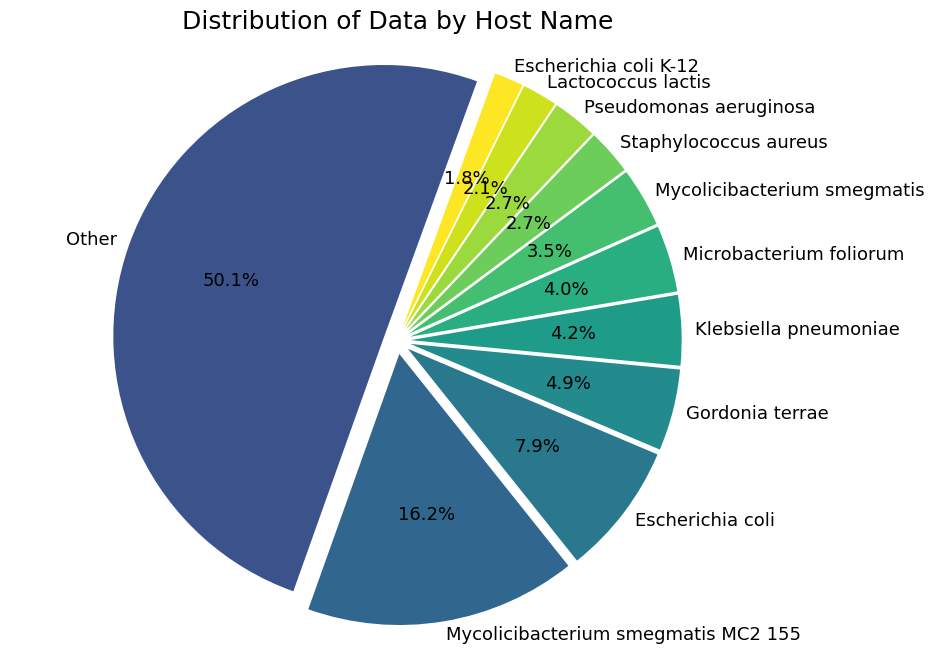

In [ ]:
plot_data_distribution_pie_chart(df, figsize=(10,8))

## Convert to Dataset and Dataloaders

### Protein Data

In [ ]:
train_df_subset = val_df.iloc[0:].copy()

In [ ]:
len(train_df_subset)

431

In [ ]:
# ESM_model_size = 'facebook/esm2_t36_3B_UR50D'
ESM_model_size = 'facebook/esm2_t33_650M_UR50D'
# ESM_model_size = 'facebook/esm2_t30_150M_UR50D'
#ESM_model_size = 'facebook/esm2_t12_35M_UR50D'

In [ ]:
%%capture
ESM_tokenizer = AutoTokenizer.from_pretrained(ESM_model_size)
ESM_model = AutoModel.from_pretrained(ESM_model_size).to(device)

In [ ]:
protein_dataset = ProteinDataset(train_df_subset, ESM_tokenizer, device=device, context_length=1024)
protein_dataloader = DataLoader(protein_dataset, batch_size=1, shuffle=False)

### DNA Data

In [ ]:
DNA_model, DNA_tokenizer = load_DNA_model(location=location, device=device)

In [ ]:
DNA_dataset = DNADataset(train_df_subset, DNA_tokenizer, device, overlap_token_count=50)
DNA_dataloader = DataLoader(DNA_dataset, batch_size=1, shuffle=False)

## Process Protein Data Through ESM2 and Collect Embeddings

I plan to run all the protein sequence data through a protein BERT model (ESM2?) and collect the CLS result of each protein for further processing.  There are up to 10 proteins per phage, so all data is set up to have either 10 proteins or <10 proteins with padding proteins to fill up to 10 proteins.  Context length of each protein is up to 1024, with padding tokens to fill up to 1024tokens.  The tensor for a given phage is therefore (10x1024), or 10 proteins each a length of 1024 amino acids.

After feeding through the 10 proteins to the ESM2 model, there are options for combination
- average CLS vectors
- take max from each CLS vector
- concatenate and run through another ESM2

#### Process in Batches

In [ ]:
# Set parameters for file name
use_case = '_val' # train/val
num_samples_analyzed = '_all' #numeric value, or 'all'
model_param_num = '_650M' #model size
num_hosts = '_5' # does not include "other" class
long_dna_removed = '_True' # whether data was fed through function to remove >100 chunked DNA
curated = '_curated' # Whether protein labels were sent through regex expression from literature

protein_folder = 'data/Protein_CLS_Embeddings/protein_cls_embeddings'
hdf5_path = file_path + protein_folder + use_case + num_samples_analyzed + model_param_num + long_dna_removed + curated + '.h5'
hdf5_path

'/content/drive/My Drive/DS_266_Final_Project_PBI/data/Protein_CLS_Embeddings/protein_cls_embeddings_val_all_650M_True_curated.h5'

In [ ]:
# Feed into model and save embeddings by batches
process_protein_to_CLS_and_store_hdf5_batched(hdf5_path, protein_dataloader, ESM_model, device=device, batch_size=100)

## Process DNA Data Through DNABERT2 and Collect Embeddings

I plan to run all the DNA sequence data through a standard DNABERT2 model in chunks.  Each gene sequence will be broken down into 100 chunks of size 512 tokens.  This is too large to feed directly to DNABERT, so I will need to feed it in sub-batches of 10.  The CLS tokens will be pulled out for each chunk of each sub-batch, and concatenated back together to make a full set of CLS tokens per phage.

The CLS tokens for each chunk will be saved by phage, along with an attention mask denoting which chunks contained genetic information and which chunks contained padding tokens

#### Process all at once

In [ ]:
#Pass tokens to model and collect CLS embeddings and attention masks
embeddings_by_phage, attention_mask_by_phage = process_DNA_to_CLS_embeddings(DNA_dataloader, DNA_model)

In [ ]:
# Save results to hdf5 file
DNA_folder = 'data/DNABERT_CLS_Embeddings/DNA_cls_embeddings'
hdf5_path = file_path + DNA_folder + use_case + num_samples_analyzed + num_hosts + long_dna_removed + curated + '.h5'
store_embeddings_in_hdf5_file(hdf5_path, embeddings_by_phage, attention_mask_by_phage)

file saved successfully


#### Process in batches

In [ ]:
# Setup hdf5 filepath for batched processing
DNA_folder = 'data/DNABERT_CLS_Embeddings/DNA_cls_embeddings'
hdf5_path = file_path + DNA_folder + use_case + num_samples_analyzed + long_dna_removed + '.h5'
hdf5_path

'/content/drive/My Drive/DS_266_Final_Project_PBI/data/DNABERT_CLS_Embeddings/DNA_cls_embeddings_train_all_True.h5'

In [ ]:
process_DNA_to_CLS_and_store_hdf5_batched(hdf5_path, DNA_dataloader, DNA_model, device=device, batch_size=100)

## Save refseq_ids and labels to maintain indexing

In [ ]:
# Set parameters for file name
use_case = '_train' # _train/_val
num_samples_analyzed = '_all' #_numeric value, or '_all'
model_param_num = '_650M' #model size
num_hosts = 25 # does not include "other" class.  Send as integer
long_dna_removed = '_True' # whether data was fed through function to remove >100 chunked DNA, _True/_False
curated = '' # Whether protein labels were sent through regex expression from literature, _curated/''

data_file_path = file_path + 'data/filtered_data/dna_protein_compiled_long_DNA_removed_50ovlp_2024_07_16.csv'
#data_file_path = file_path + 'data/filtered_data/dna_protein_compiled_curated_long_DNA_removed_50ovlp_2024_07_20.csv'

def save_refseq_and_labels_file(num_hosts, use_case, file_path, data_file_path, num_samples_analyzed, long_dna_removed, curated):

  df = load_data(data_file_path, remove_long_DNA_flag=False)
  df = trim_to_top_n_hosts(df, num_top_hosts = num_hosts)
  train_df, val_df, test_df, train_refseq_labels, val_refseq_labels, test_refseq_labels = split_data(df, train_frac = 0.8, val_frac = 0.1)

  if use_case == '_train':
    df_subset = train_df
  elif use_case == '_val':
    df_subset = val_df

  # Set file pat
  refseq_and_labels_path = 'data/RefSeq_ids/refseq_ids_and_labels'
  num_hosts = '_' + str(num_hosts)
  refseq_and_labels_path = file_path + refseq_and_labels_path + use_case + num_samples_analyzed + num_hosts + long_dna_removed + curated + '.csv'

  # Select data and save
  refseq_and_labels_df = df_subset[['refseq_id', 'adjusted_host_name']]
  refseq_and_labels_df.to_csv(refseq_and_labels_path, index=False)
  print('File saved successfully')
  return refseq_and_labels_df, refseq_and_labels_path

In [ ]:
refseq_and_labels_df, refseq_and_labels_path = save_refseq_and_labels_file(num_hosts, use_case, file_path, data_file_path, num_samples_analyzed, long_dna_removed, curated)

File saved successfully
